# **Euler–Maruyama method**

기초적인 SDE solution  
${\displaystyle \,Y_{n+1}=Y_{n}+a(Y_{n},\tau _{n})\,\Delta t+b(Y_{n},\tau _{n})\,\Delta W_{n},}$

# ***The "FRKI" method (first-order Runge-Kutta method involving the Ito coefficient).***

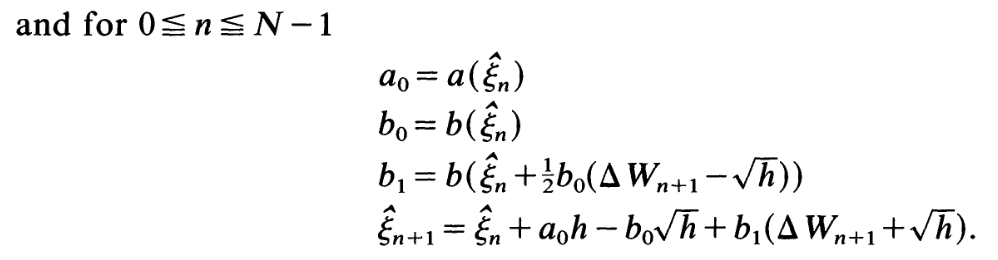


b텀에 해당되는 노이즈의 세기가 $\xi$에 영향을 주지 않는 경우 노의즈에 해당되는 텀은 사라지고 RKHG 방법으로 변하게 된다.